<a href="https://colab.research.google.com/github/BioGeMT/DLforGenomics/blob/main/notebooks/Interpreting_2D_CNN_on_miRNA_binding_site_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. miRNA target prediction: from prediction to interpretation

In this notebook we will look at a real world example from the field of miRNA target prediction. First, we will briefly describe the biological process of miRNA targating. Then, we will use state-of-the-art deep neural network to predict positive miRNA targets. And finaly, we will interpret this model to extract learned biological principles.

## 1.1. miRNA targeting

Inside our cells, we have a set of instructions called DNA, which contains the genetic code for making proteins. Proteins are crucial for various cellular functions, and they are produced based on the information stored in the DNA.

Now, miRNAs are tiny molecules in the cell that play an important role in regulating how genes are used. Think of miRNAs as molecular switches that can turn genes on or off. They don't code for proteins themselves; instead, they influence the production of proteins from other genes.

The problem with miRNA target prediction is figuring out which genes or specific pieces of genetic code are controlled by a particular miRNA. It's like trying to identify which light switches in a room control which lights.  Understanding miRNA target prediction is essential because it helps us grasp how cells fine-tune their functions and respond to different conditions, which is crucial for understanding diseases and developing potential treatments.

![](https://www.science.org/cms/10.1126/science.aav1741/asset/3253df46-f059-4297-983c-3cd6e1f0c6cb/assets/graphic/366_aav1741_fa.jpeg)

What we know is that both miRNA and their targets are RNA sequences composed from 4 letters (nucleotides) - adenine (A), thymine (T), guanine (G) and cytosine (C) and their interactions are driven by the Watson-Crick pairing - A pairs with T and C pairs with G.

![](https://microbenotes.com/wp-content/uploads/2019/04/Watson-and-Crick-DNA-Model.jpeg)

From the biological experiments we know that these pairs between miRNA and its target are important for the interaction. However, there is still no clear model describing which exact pairings need to present for a interaction to be active.

## 1.2. Computational miRNA target prediction



For more in depth description you can look at this [article](https://www.mdpi.com/2079-7737/11/12/1798).

# 2. Setup

## 2.1. Dependencies

There are several specific dependencies we will use that are not already present in Google Colab, expecialy [SHAP](https://github.com/shap/shap) and [DeepExperiment](https://github.com/katarinagresova/DeepExperiment).

**SHAP (SHapley Additive exPlanations)** is a game theoretic approach to explain the output of any machine learning model. It connects optimal credit allocation with local explanations using the classic Shapley values from game theory and their related extensions

**DeepExperiemnt** is a framework for interpreting and visualizing decisions of neural networks trained on a two-dimensional representation of interactions between miRNA and target site (or any other pair of genomic sequences).

In [30]:
!pip install tensorflow_addons gdown shap -q
!pip install git+https://github.com/katarinagresova/DeepExperiment -q

  Preparing metadata (setup.py) ... done


## 2.2. Imports

In [31]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import register_keras_serializable
import tensorflow_addons as tfa
import cv2
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from textwrap import wrap
import random
import shap
from shap.plots.colors import red_transparent_blue

from sklearn.metrics import precision_recall_curve
from sklearn import metrics

from deepexperiment.alignment import Attrament
from deepexperiment.visualization import plot_alignment, plot_miRNA_importance, plotbar_miRNA_importance
from deepexperiment.utils import one_hot_encoding, one_hot_encoding_batch
from deepexperiment.interpret import DeepShap

## 2.3. Model

We will work with the state-of-the-art model for miRNA target prediction called **miRBind** ([Klimentova et al. 2022](https://doi.org/10.3390/genes13122323)).

In [32]:
!wget https://github.com/ML-Bioinfo-CEITEC/miRBind/raw/main/Models/miRBind.h5

--2024-06-04 18:23:49--  https://github.com/ML-Bioinfo-CEITEC/miRBind/raw/main/Models/miRBind.h5
Resolving github.com (github.com)... 140.82.116.3
Connecting to github.com (github.com)|140.82.116.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ML-Bioinfo-CEITEC/miRBind/main/Models/miRBind.h5 [following]
--2024-06-04 18:23:49--  https://raw.githubusercontent.com/ML-Bioinfo-CEITEC/miRBind/main/Models/miRBind.h5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5395488 (5.1M) [application/octet-stream]
Saving to: ‘miRBind.h5.1’

miRBind.h5.1        100%[===================>]   5.15M  --.-KB/s    in 0.08s   

2024-06-04 18:23:50 (66.0 MB/s) - ‘miRBind.h5.1’ saved [5395488/5395488]



In `TensorFlow`, you can load models exported in `.h5` format using `keras.models.load_model(path_to_the_model)` and use them right away.

In [33]:
model = keras.models.load_model("miRBind.h5")
model.summary()

Model: "resnet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 50, 20, 1)]       0         
                                                                 
 batch_normalization_90 (Ba  (None, 50, 20, 1)         4         
 tchNormalization)                                               
                                                                 
 conv2d_93 (Conv2D)          (None, 50, 20, 16)        160       
                                                                 
 re_lu_87 (ReLU)             (None, 50, 20, 16)        0         
                                                                 
 batch_normalization_91 (Ba  (None, 50, 20, 16)        64        
 tchNormalization)                                               
                                                                 
 dropout_45 (Dropout)        (None, 50, 20, 16)        0    

## 2.4. Data

In [34]:
!wget https://raw.githubusercontent.com/BioGeMT/DLforGenomics/main/data/Helwak_2013/all_miRNA/miRNA_train_set.tsv -O miRNA_train_set.tsv

--2024-06-04 18:23:56--  https://raw.githubusercontent.com/BioGeMT/DLforGenomics/main/data/Helwak_2013/all_miRNA/miRNA_train_set.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2424789 (2.3M) [text/plain]
Saving to: ‘miRNA_train_set.tsv’

miRNA_train_set.tsv 100%[===================>]   2.31M  --.-KB/s    in 0.05s   

2024-06-04 18:23:56 (45.7 MB/s) - ‘miRNA_train_set.tsv’ saved [2424789/2424789]



We will load data into the pandas `DataFrame` with columns `miRNA, gene, label`. Column `miRNA` contains ~20nt long miRNA sequences. Column `gene` contains ~50nt binding sites sequences. Columns `label` is binary, value `1` marking positive pair identified by the exmeriment and value `0` marking negative pair.

In [41]:
samples = pd.read_csv('miRNA_train_set.tsv', sep='\t')
samples = samples.rename(columns={"noncodingRNA": "miRNA"})
samples.head()

,miRNA,gene,label
0,TGTAAACATCCTCGACTGGA,GTCGAGAAGTCAACGACTCAATGAAGAATTCCACTTATGGCGTGAA...,1
1,TGAGACCTCTGGGTTCTGAG,GACCTCAGAGCTCCAGGATCATCAGTAAATTTGTCATGTTATATAT...,1
2,GAGGGTTGGGTGGAGGCTCT,TGCCATAATGAACCGTCCAGCCCCTGTGGAGATCTCCTATGAGAAC...,1
3,CAAAGTGCTTACAGTGCAGG,CACCAGAATTGCCAAAGCACATATATAATAAATTAGATAAAGGGCA...,1
4,TTAGGGCCCTGGCTCCATCT,AGCCAAGTGGAGAAGGGTTCCTATCCCTGGCAGGTATCTCTGAAAC...,1


## 2.5. Seed

Setting the random seed to make experiments reproducible.

In [42]:
random.seed(42)

# 3. Prediction

Before we will dive into the interpretation of the model, we will first look at the model's prediction on one selected sample and then we will compute precision-recall curve for the whole dataset. It is reasonable to check that model is performing well before we will try to interpret it.

## 3.1. Looking at data sample

One of the interesting things about the `miRBind` model is that it works with an image representation of input data.

Input miRNA:binding site pair is encoded into so called *2D-binding matrix*. This matrix has rows corresponding to the binding site nucleotides and columns corresponding to the miRNA nucleotides. Matrix is filled with the while pixes, if given nucleotides for a Watson-Crick pairing and with the black pixel otherwise.

We can use `one_hot_encoding(miRNA, gene)` function from the `deepexperiment.utils` to do this transformation. Resulting tensor has dimensions `(1, 50, 20, 1)`, where
- the first dimension is number of samples in a batch
- the second dimension is number of rows
- the third dimension is number of columns
- and the fourth dimension is number of channels in the image

To visualize the sample, we can use `matplotlib`, but we need to remove the batch and channels dimension.

Looking at index: 0
miRNA: TGTAAACATCCTCGACTGGA
binding site: GTCGAGAAGTCAACGACTCAATGAAGAATTCCACTTATGGCGTGAATAGC


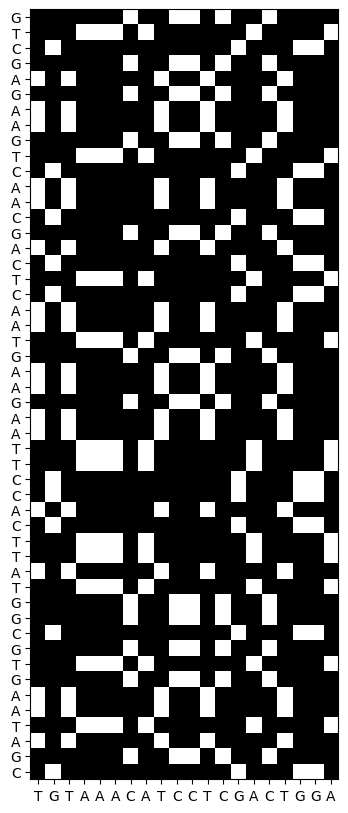

In [43]:
index = 0
print("Looking at index:", index)

miRNA = samples['miRNA'][index]
gene = samples['gene'][index]
data = one_hot_encoding(miRNA, gene)

print("miRNA:", miRNA)
print("binding site:", gene)

fig, ax = plt.subplots(1,1, figsize=(10, 10))
ax.imshow(data[0,:,:,0], cmap='gray')
ax.set_xticks(range(len(miRNA)))
ax.set_xticklabels(miRNA)
ax.set_yticks(range(len(gene)))
ax.set_yticklabels(gene)
plt.plot();

## 3.2. Scoring miRNA:binding site pairs

To get the `miRBind`'s prediction, we call `predict()` method, passing the data in the 2D-binding matrix format. This method returns an array with predictions. Lenght of returned array equals to the number of samples in a batch that was sent to the `predict()` method (1 in our case). Each element of the array contains two walues:
- probability that given sample belongs to the negative class
- probability that given sample belongs to the positive clas

This is because the `miRBind` model was trained as a multiclass clasification. Sum of these values is always 1.

In [53]:
index = 7
print("Looking at index:", index)

miRNA = samples['miRNA'][index]
gene = samples['gene'][index]
data = one_hot_encoding(miRNA, gene)

print("True label:", samples['label'][index])

preds = model.predict(data, verbose=0)
print("Prediction:\n  negative ", preds[0][0], "\n  positive ", preds[0][1])

Looking at index: 7
True label: 1
Prediction:
  negative  0.07287126 
  positive  0.92712873


We can also score multiple samples at a time and compute the precision-recall curve.

To transform multiple samples into a 2D-binding matrix, use `one_hot_encoding_batch()` function, passing it a `DataFrame` with samples. It will produce:
- `data` with shape (num_of_samples, 50, 20, 1) with encoded input samples
- array `labels` with lenglet of number of input samples containing true labels

To get a prediction, we again use the `predict()` method. It this case, we will get and array of predictions with the length of input samples. Each element of array contains two values (probability that given sample belongs to the negative and positive class). To compute a precision-recall curve, we would need an array of probabilities that a given samples belong to the positive class, so we extract only those values (`pred_f = pred[:, 1]`).

1025/1025 [==============================] - 7s 7ms/step
Precision-recall AUC: 0.9765925074893158


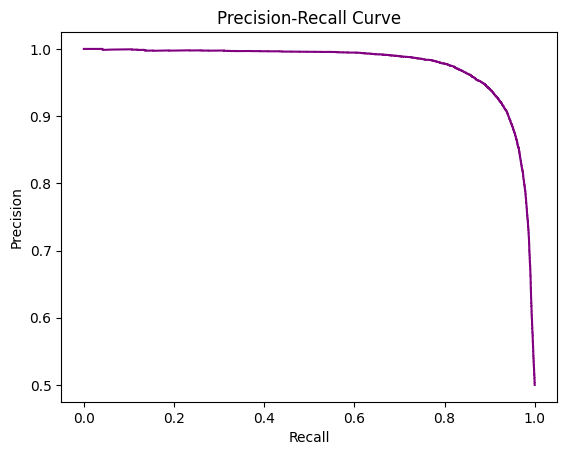

In [54]:
# prepare data for the model
data, labels = one_hot_encoding_batch(samples)

# get predictions
pred = model.predict(data)
pred_f = pred[:, 1]

#calculate precision and recall
precision, recall, thresholds = precision_recall_curve(labels, pred_f)

# calculate precision-recall AUC
print("Precision-recall AUC:", metrics.auc(recall, precision))

#create precision recall curve
fig, ax = plt.subplots()
ax.plot(recall, precision, color='purple')

#add axis labels to plot
ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

#display plot
plt.show()

# 4. Interpretation

## 4.1. SHAP attribution scores

Since input of our neural network is in the image format, we can use an interpretation technique from the computer vision. In this section, we will use the SHAP method.

Due to computational complexity, we will use a subset of the  data as background samples. We will use 100 samples.

Note: you can utilize GPU for faster computation.

In [55]:
rand_samples = samples.sample(n=100, replace=False, random_state=42).reset_index(drop=True)
background, _ = one_hot_encoding_batch(rand_samples)

In [56]:
# these layers are not supported, so the workaround presented on the github is to use passthrough
shap.explainers._deep.deep_tf.op_handlers["AddV2"] = shap.explainers._deep.deep_tf.passthrough
shap.explainers._deep.deep_tf.op_handlers["FusedBatchNormV3"] = shap.explainers._deep.deep_tf.passthrough

# create explainer for the model and background
explainer = shap.DeepExplainer(model, background)

/usr/local/lib/python3.10/dist-packages/shap/explainers/_deep/deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")


In [57]:
# explain one input data sample
index = 7
miRNA = samples['miRNA'][index]
gene = samples['gene'][index]
data = one_hot_encoding(miRNA, gene)
print("True label:", samples['label'][index])

preds = model.predict(data, verbose=0)
print("Prediction:\n  negative ", preds[0][0], "\n  positive ", preds[0][1])

shap_values = explainer.shap_values(data)
neg_shap, pos_shap = shap_values[:, :, :, :, 0], shap_values[:, :, :, :, 1]

/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


True label: 1
Prediction:
  negative  0.07287126 
  positive  0.92712873


SHAP interpretation techniques produces a heatmap with tha attribution score for each pixel on the input. Red pixels were positively influencing the assignent to the positive class and blue pixels were negatively influencing assignment to the positive class. Attribution to the negative class is not plotted, but it is symmetric in this case where we have only two classes.

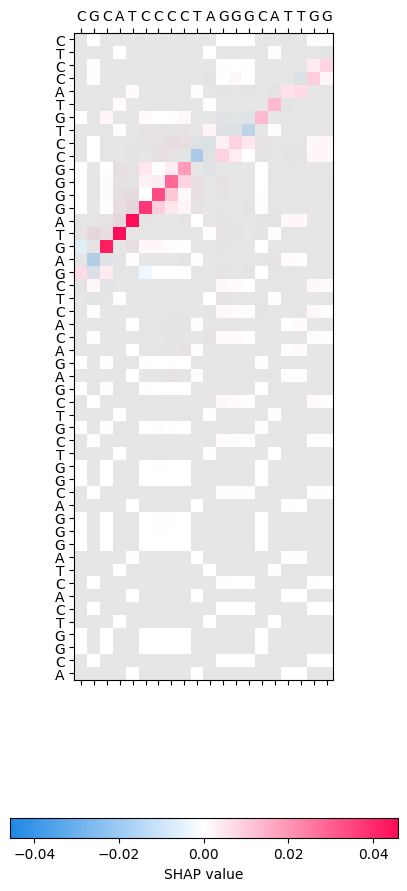

In [58]:
fig, ax = plt.subplots(1,1, figsize=(5, 12))

abs_vals = np.stack(np.abs(pos_shap.sum(-1)), 0).flatten()
max_val = np.nanpercentile(abs_vals, 99.9)
ax.imshow(data[0,:,:,0], alpha=0.1, cmap='gray')
im = ax.matshow(pos_shap[0,:,:,0], cmap=red_transparent_blue, vmin=-max_val, vmax=max_val)
ax.set_xticks(range(len(miRNA)))
ax.set_xticklabels(miRNA)
ax.set_yticks(range(len(gene)))
ax.set_yticklabels(gene)

cb = plt.colorbar(im, label="SHAP value", orientation="horizontal")

plt.show();

# 5. Extracting biological knowledge

Computing SHAP attribution scores can be enough for image data where we understand the image just by looking at it. For the image with a cat we would expect a cat to be important for a model and not its surrounding. But in this case, we don't understand which parts of the input are supposed to be important.

Moreover, we don't even understand the biological process enough to verify the model by hand. We only have the experimental data that gives are positive and negative pairs (miRNAs with targets and miRNAs with non-targets). We don't know which parts of sequences are more or less important for the interaction.

But the neural network could be able to know that. In the *Prediction* section we saw that our model has a hight predictive power. To achieve that the network had to find some underlying biological principes in the training data. And using the right interpretation and visualization techniques, we could extract these learned biological principles from the network.

## 5.1. Attrament (attribution sequence alignment)

The Attrament (attribution sequence alignment) technique ([Gresova et al. 2023](https://doi.org/10.3390/biology12030369)) is based on the principles of dynamic programming for semi-global sequence alignment computed on top of attribution scores obtained from interpreting the trained neural network by the SHAP method.

More simply, input "image" is encoding all possible alignments between miRNA and target sequence. SHAP atttribution scores are highliting important parts. And Attrament is computing the most probable aligment.

`Attrament()` is available in [DeepExperiment](https://github.com/katarinagresova/DeepExperiment) package. It produces three sequences on output:
- align_gene:
- align_score:
- align_miRNA:



In [59]:
attrament = Attrament()
align_gene, align_score, align_miRNA = attrament(miRNA[::-1], gene, pos_shap[0,:,:,0])

To see the alignment, we can simply plot the aligned sequences

In [60]:
print(" ".join(align_gene))
print(" ".join(align_miRNA))

A C G G T C A C T A G G G A C G G T C G T C G A G A C A C T C G A G T A G G G G C C T G T A C C T C -
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - C G C A T C C C C T A G G G C A T T G G


## 5.2. Visualization

[DeepExperiment](https://github.com/katarinagresova/DeepExperiment) package also provides methods for visualization.

`plot_alignment(align_gene, align_score, align_miRNA)` will plot aligned sequences colored by the attribution scores - brighter red pair is more important.

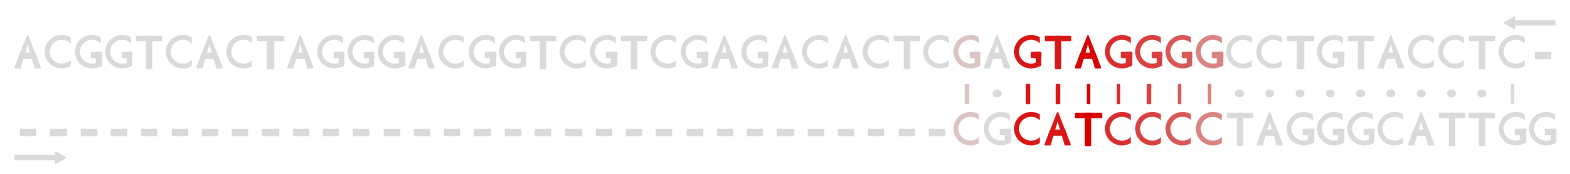

In [61]:
plot_alignment(align_gene, align_score, align_miRNA)

`plotbar_miRNA_importance(align_miRNA, align_score)` will visualize importance of individual positions in a miRNA.

/usr/local/lib/python3.10/dist-packages/deepexperiment/visualization.py:242: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(np.arange(1, len(miRNA_s) + 1))


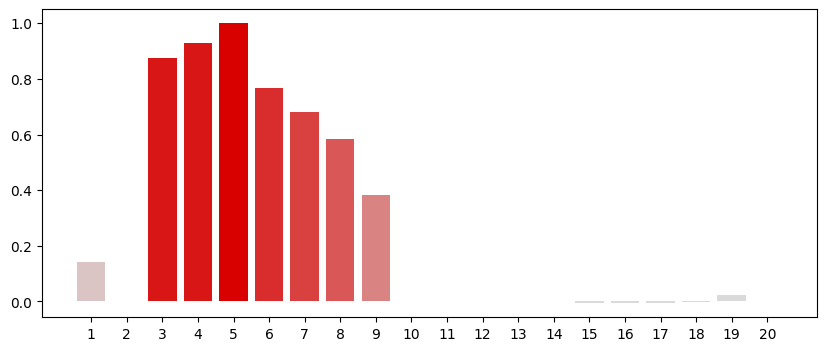

In [62]:
plotbar_miRNA_importance(align_miRNA, align_score)

# Excercise 1: Visualize different data samples

Through the whole notebook, we have been working with a sigle data sample. Create a function that will take any `miRNA` and `gene` sequence on the input and it will return `align_gene`, `align_score` and `align_miRNA`.

In [ ]:
### Excercise 1 ###

def interpret_sample(miRNA, gene):

    ## encode miRNA and gene into 2D-binding matrix

    ## print true label

    ## pring label predicted by a model

    ## compute positive and negative SHAP values

    ## compute alignment using the Attrament

    ## plot alignment

    ## plot miRNA importance

After you complete the `interpret_sample()` function, you can tast it by running following cells using different indices (or even your custom miRNA and gene sequences).

In [ ]:
index = 0
print("Looking at index:", index)

miRNA = samples['miRNA'][index]
gene = samples['gene'][index]

align_gene, align_score, align_miRNA = interpret_sample(miRNA, gene)

In [ ]:
plot_alignment(align_gene, align_score, align_miRNA)

In [ ]:
plotbar_miRNA_importance(align_miRNA, align_score)

# Exercise 2: Load your own model

If you have your own trained model, load it and try interpretation on it.